✅ Dataset loaded successfully!

Detected columns: ['F1', 'F2', 'F3', 'F4', 'Label']

First 5 rows:
    F1   F2   F3   F4        Label
0  5.1  3.5  1.4  0.2  Iris-setosa
1  4.9  3.0  1.4  0.2  Iris-setosa
2  4.7  3.2  1.3  0.2  Iris-setosa
3  4.6  3.1  1.5  0.2  Iris-setosa
4  5.0  3.6  1.4  0.2  Iris-setosa
Detected label column: 'Label'


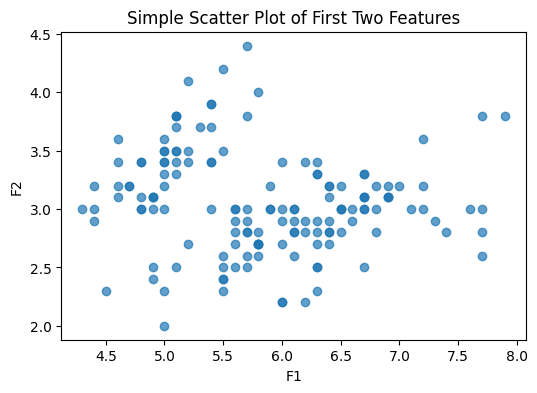

✅ Dataset initialized with 150 samples
Detected classes: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
Train: 105, Val: 15, Test: 30
IrisNet(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=3, bias=True)
  )
)
Epoch [1/100] Loss: 1.1858, Acc: 0.3611, Val Loss: 1.2356, Val Acc: 0.1333
Epoch [2/100] Loss: 1.1127, Acc: 0.3212, Val Loss: 1.1057, Val Acc: 0.2000
Epoch [3/100] Loss: 1.0149, Acc: 0.4201, Val Loss: 0.9567, Val Acc: 0.7333
Epoch [4/100] Loss: 0.9181, Acc: 0.8750, Val Loss: 0.7975, Val Acc: 0.9333
Epoch [5/100] Loss: 0.8274, Acc: 0.8707, Val Loss: 0.6461, Val Acc: 0.8667
Epoch [6/100] Loss: 0.7711, Acc: 0.7917, Val Loss: 0.5202, Val Acc: 0.8667
Epoch [7/100] Loss: 0.6938, Acc: 0.7483, Val Loss: 0.4303, Val Acc: 0.8667
Epoch [8/100] Loss: 0.6165, Acc: 0.7839, Val Loss: 0.3652, Val Acc: 0.8667
Epoch [9/100] Loss

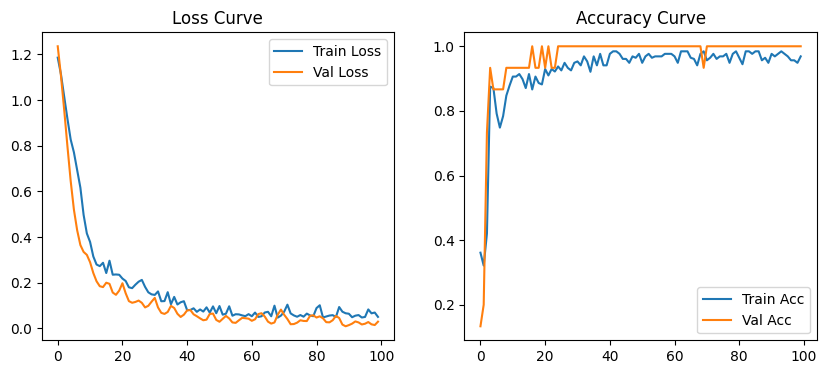

In [6]:
# 🌸 PyTorch ANN for Iris Dataset (Auto Column Detection, Refined No Seaborn)

# 1️⃣ Import Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch.nn as nn
import torch.optim as optim

# 2️⃣ Load Dataset Safely
file_path = 'https://raw.githubusercontent.com/Casas846/ANN_Training/main/iris_flower.csv'

# Try reading with various delimiters and handle bad lines
df = None
for sep in [',', ';', '\t', ' ']:
    try:
        df = pd.read_csv(file_path, sep=sep, on_bad_lines='skip')
        if df.shape[1] > 1:
            break
    except Exception:
        continue

if df is None or df.shape[1] <= 1:
    raise ValueError("❌ Unable to read dataset properly. Please check CSV format.")

print("✅ Dataset loaded successfully!\n")
print("Detected columns:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())

# Detect last column as label
label_col = df.columns[-1]
print(f"Detected label column: '{label_col}'")

# 3️⃣ Basic Visualization (only if dataset has at least 2 columns)
if df.shape[1] >= 2:
    plt.figure(figsize=(6,4))
    plt.scatter(df.iloc[:,0], df.iloc[:,1], alpha=0.7)
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.title('Simple Scatter Plot of First Two Features')
    plt.show()
else:
    print("⚠️ Not enough columns for visualization.")

# 4️⃣ Custom Dataset Class (auto-detect label)
class IrisDataset(Dataset):
    def __init__(self, data):
        self.label_col = data.columns[-1]

        # Encode label
        le = LabelEncoder()
        data['label_encoded'] = le.fit_transform(data[self.label_col])
        self.classes = list(le.classes_)

        # Scale features
        scaler = StandardScaler()
        features = scaler.fit_transform(
            data.drop([self.label_col, 'label_encoded'], axis=1)
        )

        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(data['label_encoded'].values, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

iris_dataset = IrisDataset(df)
print(f"✅ Dataset initialized with {len(iris_dataset)} samples")
print(f"Detected classes: {iris_dataset.classes}")

# 5️⃣ Split Dataset and Create DataLoaders
total_size = len(iris_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_data, temp_data = random_split(iris_dataset, [train_size, val_size + test_size])
val_data, test_data = random_split(temp_data, [val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

# 6️⃣ Define ANN Model (auto input/output size)
input_size = iris_dataset.features.shape[1]
output_size = len(iris_dataset.classes)

class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 8),
            nn.ReLU(),
            nn.Linear(8, 6),
            nn.ReLU(),
            nn.Linear(6, output_size)
        )

    def forward(self, x):
        return self.net(x)

model = IrisNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(model)

# 7️⃣ Training & Validation
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / len(labels)

num_epochs = 100
model_path = "best_model.pth"

epoch_losses = []
epoch_accuracies = []
val_accuracies = []
val_losses = []
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(outputs, labels)
        epoch_loss += loss.item()
        epoch_accuracy += acc

    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            outputs_val = model(inputs_val)
            loss_val = criterion(outputs_val, labels_val)
            acc_val = calculate_accuracy(outputs_val, labels_val)
            val_loss += loss_val.item()
            val_accuracy += acc_val
    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), model_path)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

print(f"\\n✅ Training complete. Best Validation Accuracy: {best_val_accuracy:.4f}")

# 8️⃣ Plot Loss & Accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epoch_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.show()
